# Frame sums and XGM with dark substraction

In this tutorial, we show how to reduce raw data in order to obtain the sum of all pixels for each frame in the run as well as the XGM (per frame) values.

We start by importing the modules we are going to use:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import euxfel_scs_tools as scs

In [2]:
import xarray as xr
xr.set_options(display_style='text')

In the following cell, we define run-specific information:

In [3]:
proposal = 2530  # proposal number
run = 50  # run number
dark_run = 49
pattern = ['image', 'dark'] * 99 + ['endimage']  # the pattern of frames in each train
dirname = 'processed_runs_xgm'  # directory where we are going to save processed data

The length of `pattern` list must be the same as the number of frames per train. `dirname` can be any path, but in the case of reducing data, the resulting files cannot be written if you do not have writing priviledges in that directory. Accordingly, it is most safe to keep all files you process in your user directory.

## Data reduction

### Dark data

First, we have to process the dark run using standard processing. These results are then used to perform a background substraction during the calculation of image sums.

From the notebook `scs.reduction_std` can be called to process the data with standard processing. This function is going to submit 16 jobs to the queue (one per DSSC module). Function's signature is:

```
scs.reduction_std(proposal, run, pattern, frame_types=None, trains=None, njobs=40, dirname=None)
```

The individual arguments are:

- `proposal` - proposal number
- `run` - run number
- `pattern` - the pattern of frames in each train
- `frame_types` - a list of frame types that are reduced. Its elements must be from `pattern`. It defaults to `None` and all frame types found in pattern will be processed.
- `trains` - the list of train indices whose frames are reduced. It defaults to `None` and all trains in the run will be summed.
- `njobs` - the number of jobs executed on each node
- `dirname` - directory name where reduced files are going to be saved

We call the function for both run and corresponding dark run. The function calls are:

In [4]:
scs.reduction_std(proposal=proposal, run=dark_run, pattern=pattern, dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


### Image sums with background substraction

This function expects a processed dark run (standard processing). So we have to wait for the jobs submitted above to finish.

For the summed pixel values with background substraction included the following formula is used:

```
sum = run_image_sum - average_over_pulses(run_dark_sum)
      - [average_over_trains(dark_run_image_sum) - average_over_trains_and_pulses(dark_run_dark_sum)]
```

From the notebook `scs.reduction_sum_bg_sub` can be called. This function is going to submit 16 jobs to the queue (one per DSSC module). Function's signature is:

```
scs.reduction_sum_bg_sub(proposal,
                         run,
                         pattern,
                         dark_run,
                         frames={'image': 'image', 'dark': 'dark'},
                         dark_run_frames={'image': 'image', 'dark': 'dark'},
                         trains=None,
                         njobs=40,
                         dirname=None):
```

The individual arguments are:

- `proposal` - proposal number
- `run` - run number
- `pattern` - the pattern of frames in each train
- `dark_run` - dark run number
- `frames` - what frame type is considered to be "image" and what is considered to be "dark" in pattern. This is used for pump-probe reduction when frames can be called "pumped", "unpumped", etc. or when in pattern dark frames are called "intradark". This is like a lookup-table which allows generalisation independent of the naming of frames in `pattern`.
- `dark_run_frames` - similar to `frames`. More precisely, what is the name of image frame and dark frame in the dark run.
- `trains` - the list of train indices whose frames are reduced. It defaults to `None` and all trains in the run will be summed.
- `njobs` - the number of jobs executed on each node
- `dirname` - directory name where reduced files are going to be saved

Let us say we want to reduce all image-frames and extract XGM values for all of them. The function call is:

In [5]:
scs.reduction_sum_bg_sub(proposal=proposal, run=run, pattern=pattern, dark_run=dark_run, dirname=dirname,
                         frames={'image': 'image',
                                 'dark': 'dark'},
                         dark_run_frames={'image': 'image',
                                          'dark': 'dark'},
                         trains=None, njobs=40)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


After some time (in my case 2 min), all jobs are completed and in `dirname` directory `run_50` is created. Inside that directory, 16 `.h5` files are created with names `module_NUM_sum_bg_sub.h5`, where `NUM` is the module number (0, 1, 2,... 15). In each HDF5 file, two arrays are saved:

- `FRAME_TYPE_sum_bg_sub`, where `FRAME_TYPE` is what we passed as `frame_type` previously.
- `xgm`, where "per-frame" XGM data is saved

In addition, two more directories are created:

- `slurm_log`, where all `.out` files are saved
- `autogenerated_scripts`, where all scripts for individual nodes are saved

These directories are used for debugging only and can be deleted.

## Reduced data reading

In order to read all previously created files and combine them into `xarray`, `scs.read` function can be called. Its signature is:

```
scs.read(dirname, run, reduction_type, data)
```

The individual arguments are:

- `dirname` - directory name where reduced files were saved
- `run` - run number
- `reduction_type` - this is the type of reduced data read. In our case, we use `sum`.
- `data` - data to be read from an HDF5 file. Because we summed image frames, this is going to be `image_sum`.

To read the data wit dark-frame substraction:

In [6]:
image_sum, xgm = scs.read(dirname=dirname, run=run, reduction_type='sum_bg_sub', dataset='image_sum')

In [7]:
image_sum.shape

(16, 597762)

### Image sums

Since the dimension of `image_sum` is 2, we need to reduce its first dimension. For instance, we can sum over the whole modules.

Averaged summed intensity: 1273.3103674081085


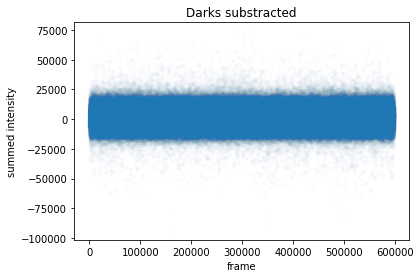

In [8]:
detector_sum = np.sum(image_sum, axis=0);
plt.plot(detector_sum, '.', alpha=0.01)
plt.xlabel('frame')
plt.ylabel('summed intensity')
plt.title('Darks substracted')
print('Averaged summed intensity:', np.mean(detector_sum.data))

### XGM data as function of image sum

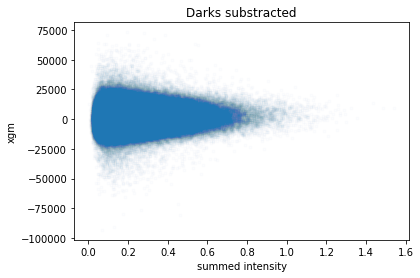

In [9]:
plt.plot(xgm, detector_sum, '.', alpha=0.01)
plt.xlabel('summed intensity')
plt.ylabel('xgm')
plt.title('Darks substracted');

#### Only selected modules

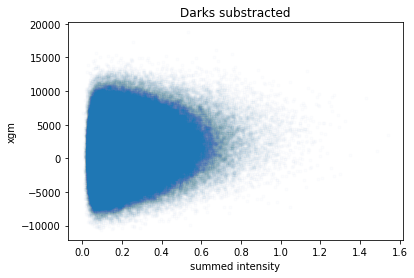

In [10]:
selected_modules = np.sum(image_sum.data[[i in (0,7,8,15) for i in range(16)]], axis=0)
plt.plot(xgm, selected_modules, '.', alpha=0.01)
plt.xlabel('summed intensity')
plt.ylabel('xgm')
plt.title('Darks substracted');